## Exercises for Physical Models for Living Systems, homework 4
Group members:
* Golan Rodrigo 1142802
* Zoppellari Elena 2076715

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

We generate the spikes of 2000 neurons using a non-homogeneous Poisson process in 2000 time steps.

We consider the two following situations:
1. the firing rate $\lambda_t$ equal for every neuron
2. the firing rate $\lambda_{t,i}$ is different for each neuron

In both cases we sample $\lambda_t$ from a distribution $Q(\lambda) = r e^{-r\lambda}$, using different values of $r$ in order to visualize the impact of this parameter in the strike generation. Naturally in the first case the generated $\lambda_t$ are $1xT$ , since every neuron at time step $t$ will have the same $\lambda_t$, while in the second case the generated $\lambda_t$ are $N x T$ . 
Then, we generate spikes using a homogenous poisson process, with firing rate chosen as the max $\lambda_{max} = max\{\lambda_{t}\}$. Since we are interested in generating spikes according to a non-homogeneous Poisson process, we perform a thinning rejecting the samples if the following condition is satisfied: 
$$
\frac{\lambda_{t}}{\lambda_{max}} < \chi, \qquad \chi \sim \mathcal{U}(0,1)
$$


The following code is optimized in order to perform also with higher numbers of neurons and timesteps (tested up to $N=10000$, $T=10000$). However, to improve visibility we have set lower values.

In [46]:
np.random.seed(8122023)
neurons_spikes = np.zeros((N, T)) # initialize neuron spikes 

def gen_lambda(r, T):
    lambda_j = np.random.exponential(scale = (1/r), size=T)     # time series lambda(t)
    return lambda_j, np.max(lambda_j)


# homogeneous Poisson Process with the same firing rate for each neuron
def same_hpp(lambda_max, T, N):
    assert isinstance(T, int)  , 'T must be integer'
    
    spikes = np.zeros((N,T), dtype=int)
    
    spike_times = np.cumsum(np.random.exponential(scale=1/lambda_max, size=(N,T)), axis=1)  
    # Ensure spike indices are within the valid range [0, T-1]
    spike_indices = np.array([np.clip( np.searchsorted(spike_times[i,:], np.arange(T)), 0, T-1) for i in range(N)]) 

    # Use indexing to set spikes at the corresponding indices
    spikes[np.arange(N)[:, np.newaxis], spike_indices] = 1

    return spikes
        
       
# thinning
def thinning(spikes_matrix, lambda_max, lambda_j):
    '''
    spikes_matrix: binary matrix, 1 if a spike occurs in neuron i at time j
    
    '''
        
    k = np.count_nonzero(spikes_matrix)
    #print(k)
    ones = np.ones(k)
    zeros = np.zeros(k)
    uni = np.random.uniform(size=k)
    
    index_thin = spikes_matrix == 1 
    lambda_j_matrix = np.vstack([np.copy(lambda_j) for _ in range(N)])
    #print(np.array(index_thin).shape, "-"*10, lambda_j_matrix.shape)
    condition_thin = lambda_j_matrix[index_thin]/lambda_max < uni
    #print(condition_thin)
    thinned = np.where(condition_thin, zeros, ones)
    spikes_matrix[index_thin] = thinned
    #print(np.count_nonzero(spikes_matrix))
    
    return spikes_matrix

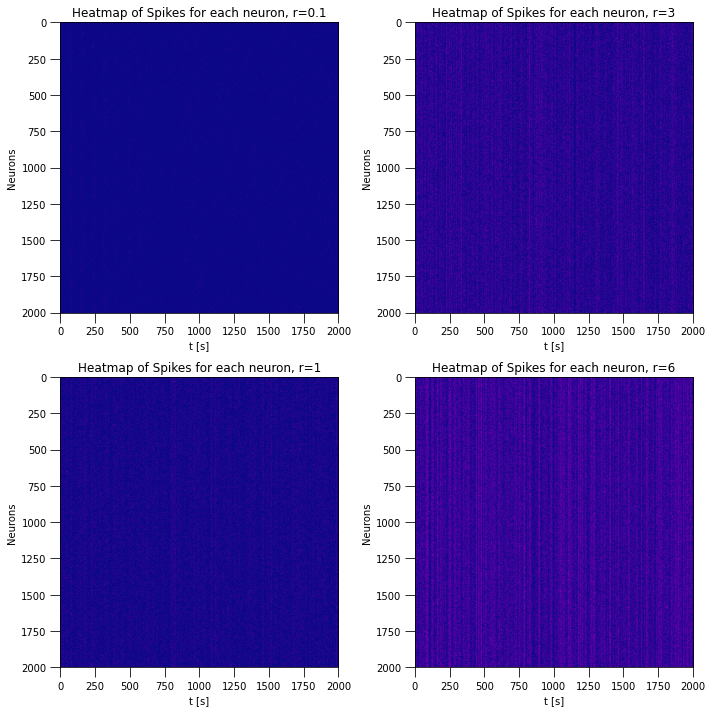

Wall time: 2.72 s


In [56]:
%%time

T = 2000  # number of time intervals
N = 2000  # number of neurons
r_range = [0.1, 1, 3, 6]
dt = 0.01

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# simulation
for i, r in enumerate(r_range):
    lambda_j, lambda_max = gen_lambda(r, T)  
    neurons_spikes = same_hpp(lambda_max, T, N)
    neurons_spikes = thinning(neurons_spikes, lambda_max, lambda_j)
    ax[i%2][i//2].imshow(neurons_spikes, cmap='plasma', aspect='auto')
    ax[i%2][i//2].set_title('Heatmap of Spikes for each neuron, r={}'.format(r), fontsize=12)
    ax[i%2][i//2].set_xlabel('t [s]', fontsize=10)
    ax[i%2][i//2].set_ylabel('Neurons', fontsize=10)

    ax[i%2][i//2].tick_params(axis='both', which='major', labelsize=10, length=10)
    ax[i%2][i//2].set_xticks(range(0,2001,250))
    ax[i%2][i//2].set_yticks(range(0,2001,250))

plt.tight_layout()
plt.show()

From the plot above, it can be observed that the spikes of different neurons are correlated when $\lambda_t$ is the same for all neurons as there seems to be a visible pattern. It is worth noting that increasing $r$ lowers the time intervals and the pattern becomes more recognizable as consequence. 

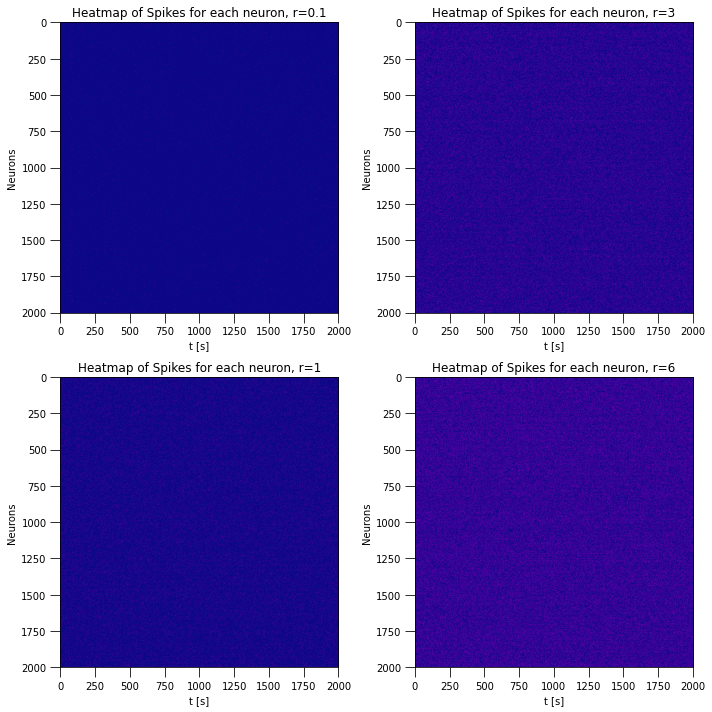

Wall time: 21.6 s


In [59]:
%%time

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# simulation
for i, r in enumerate(r_range):
    N=1
    for j in range (2000): # 2000 is the number of neurons
        lambda_j, lambda_max = gen_lambda(r, T)  
        neurons_spikes = np.zeros((N, T)) # initialization
        neurons_spikes = same_hpp(lambda_max, T, N)
        neurons_spikes = thinning(neurons_spikes, lambda_max, lambda_j)
        if (j==0):
            neurons_spikesall=neurons_spikes.copy()
        else:
            neurons_spikesall=np.vstack((neurons_spikesall, neurons_spikes))
    ax[i%2][i//2].imshow(neurons_spikesall, cmap='plasma', aspect='auto')
    ax[i%2][i//2].set_title('Heatmap of Spikes for each neuron, r={}'.format(r), fontsize=12)
    ax[i%2][i//2].set_xlabel('t [s]', fontsize=10)
    ax[i%2][i//2].set_ylabel('Neurons', fontsize=10)

    ax[i%2][i//2].set_xticks(range(0,2001,250))
    ax[i%2][i//2].set_yticks(range(0,2001,250))
    ax[i%2][i//2].tick_params(axis='both', which='major', labelsize=10, length=10)

plt.tight_layout()
plt.show()

In this case, instead, we can observe a less structured image, suggesting little correlation across neurons. This is compatible with the choice of independent firing rates.